Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import musdb

import os
import numpy as np
import librosa
from librosa import display
from IPython import display as ipd
import matplotlib.pyplot as plt

import mir_eval
from tabulate import tabulate

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
# set sample rate
sr = 44100

Directory Locations

In [3]:
# new_dataset_root and mus_dataset_root should be set to exactly the same strings as in DataGenerator.ipynb
new_dataset_root = '/Users/axelborgmo/NYU/Classes/Fall_2021/MIR/MIR-Final-Project/new_dataset_root'

mus_dataset_root = '/Users/axelborgmo/NYU/Classes/Fall_2021/MIR/MIR-Final-Project/musdb18'

phase_directory = new_dataset_root + 'phase/'

est_specs_stored = new_dataset_root + 'est'
target_specs_stored = new_dataset_root + 'target'
phase_stored = new_dataset_root + 'phase'

if mus_dataset_root == '/Users/benschwartz/datasets/musdb18' or new_dataset_root == '/Users/benschwartz/Downloads/testnumpy1/':
    raise Exception("Change both root directories above")

In [4]:
# set a path to save model weights, which should be where included checkpoint file is located 
checkpoint_path = '/Users/axelborgmo/NYU/Classes/Fall_2021/MIR/MIR-Final-Project/checkpoints/'
if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)
    
#if checkpoint_path == '/Users/axelborgmo/NYU/Classes/Fall_2021/MIR/MIR-Final-Project/checkpoints':
 #   raise Exception("Change checkpoint_path to valid path on your computer")

In [5]:
os.listdir(checkpoint_path)

['checkpoint', '.index', '.data-00000-of-00001']

Load and Prepare Data for Training Autoencoder 

In [6]:
# fill arrays with predicted and ground truth spectrograms
predicted_specs = []
truth_specs = []

num_samples = len(os.listdir(est_specs_stored))
print(f"{num_samples} total samples")

for i in range(num_samples):
    filename = str(i) +".npy"
    pred_spec = np.load(os.path.join(est_specs_stored, filename))[1:,: 512]
    true_spec = np.load(os.path.join(target_specs_stored, filename))[1:,:512]

    if pred_spec.shape == (1024, 512) and true_spec.shape==(1024, 512):
        predicted_specs.append(pred_spec)
        truth_specs.append(true_spec)
    
predicted_specs = np.asarray(predicted_specs)    
truth_specs = np.asarray(truth_specs)   

100 total samples


In [7]:
# add axis to conform to model 
predicted_specs = predicted_specs[..., tf.newaxis]
truth_specs = truth_specs[..., tf.newaxis]

input_shape = predicted_specs.shape[1:]

Build and Train Autoencoder 

In [8]:
# define model 
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=input_shape),
          layers.BatchNormalization(),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2), 
          layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.BatchNormalization(),
          layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
          layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
        ])

        self.decoder = tf.keras.Sequential([
          layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'),
          layers.BatchNormalization(),
          layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'), 
          layers.BatchNormalization(),
          layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(32, kernel_size=3, activation='relu', padding='same'), 
          layers.Conv2D(1, kernel_size=(1, 1), activation='relu', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# instantiate it
autoencoder = Denoise()

In [9]:
# create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                monitor='val_loss',
                                                mode='min',
                                                save_weights_only=True,
                                                verbose=False,
                                                save_best_only=True)

# create early stop callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=False)

In [10]:
#autoencoder.built = True
autoencoder.load_weights(checkpoint_path)

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [12]:
show_model_summary = False

if show_model_summary:
    autoencoder.encoder.summary()
    print("\n\n")
    autoencoder.decoder.summary()

In [13]:
history = autoencoder.fit(predicted_specs, truth_specs,
                validation_split=.2,
                epochs=5,
                shuffle=True,
                verbose=True,
                callbacks = [cp_callback, early_stop])
print(f" minimum loss: {min(history.history['loss'])} ")

Epoch 1/5
3/3 [==============================] - 107s 29s/step - loss: 0.1432 - val_loss: 1.5196
Epoch 2/5
3/3 [==============================] - 91s 27s/step - loss: 0.1458 - val_loss: 1.5657
Epoch 3/5
3/3 [==============================] - 88s 26s/step - loss: 0.1678 - val_loss: 1.5144
Epoch 4/5
3/3 [==============================] - 88s 27s/step - loss: 0.1481 - val_loss: 1.5453
Epoch 5/5
3/3 [==============================] - 85s 25s/step - loss: 0.1787 - val_loss: 1.5887
 minimum loss: 0.14316679537296295 


In [14]:
predicted_specs.shape

(99, 1024, 512, 1)

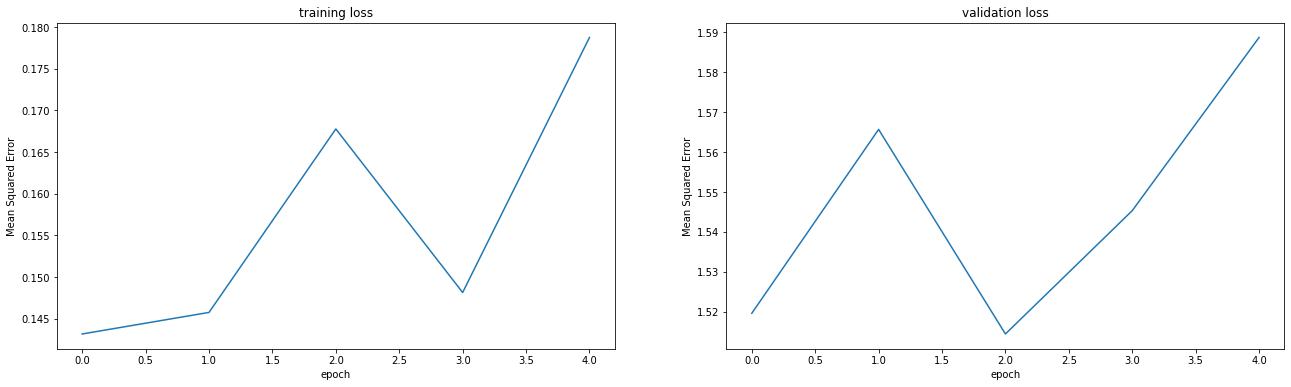

In [15]:
plot_training = True

if plot_training:
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=False)
    ax[0].plot(history.history['loss'])
    ax[0].set_title('training loss')
    ax[0].set_ylabel('Mean Squared Error')
    ax[0].set_xlabel('epoch')
    
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('validation loss')
    ax[1].set_ylabel('Mean Squared Error')
    ax[1].set_xlabel('epoch')
    
    fig.set_figwidth(22)
    fig.set_figheight(6)
    plt.show()

In [16]:
# create handles for MUS training and test sets
mus = musdb.DB(download=True, root=mus_dataset_root, subsets="train")
mus_test = musdb.DB(download=True, root=mus_dataset_root, subsets="test")

Produce Spectrograms and Audio to Evaluate Dataset

In [17]:
def predict_function(sample_num, phase_directory=phase_directory, subset='training'):
    """ Takes a sample from the training or test set and outputs audiofiles for: 1) the Spleeter estimate post-processesing through the autoencoder, 2) the Spleeter estimate pre-processing and 3) the ground truth stem.
    
    Parameters
    ----------
    
    sample_num: int 
        the number of a track in Musdb18
        
    phase_location: str 
        path to directory with phase information, which should be exactly the same as "phase_stored" defined in DataGenerator.ipynb
    
    subset: str
        whether the sample is drawn from the training or test subsets [not yet implemented]
        
    Returns
    -------
    
    none
    
    """
        
# draw sample; save Spleeter estimated spectrogram as variable 
    sample = predicted_specs[sample_num, :, :, :]
    spleeter_spec = sample

    sample = np.expand_dims(sample, axis=0)
    
# process with autoencoder model   
    processed_spec = autoencoder.predict(sample)
    
# resize    
    processed_spec = processed_spec[0,...,0]
    disp_processed = processed_spec
    processed_spec = np.pad(processed_spec, [(1,0), (0,0)])
    
# retrieve phase of mixture
    phase_stored = phase_directory + str(sample_num) + '.npy'
    phase = np.load(phase_stored)
    phase = phase[:,:512]
    phase = np.exp(phase * 1j)
    
# combine with STFT magnitudes and invert 
    with_phase = processed_spec*phase
    processed_audio =librosa.istft(with_phase)
    
    
    spleeter_spec = np.squeeze(spleeter_spec)
    disp_spleeter = spleeter_spec
    

    spleeter_spec = np.pad(spleeter_spec, [(1,0), (0,0)])
    spleeter_audio = librosa.istft(spleeter_spec*phase)
    
    
# get ground truth 
    truth_spec = truth_specs[sample_num, :, :]
    truth_spec = np.expand_dims(truth_spec, axis=0)


    truth_spec = truth_spec[0,...,0]
    disp_truth = truth_spec


    track = mus[sample_num]
    track.chunk_start = 10.0
    track.chunk_duration = 5.0
    name = track.name
    name = "Sample " + str(sample_num) + ": Bass from " + "\"" + name + "\"" 
    groundtruth_audio = track.targets['bass'].audio.T


    return groundtruth_audio, spleeter_audio, processed_audio





In [18]:
def evaluate_function(n_sources):
    """ Evaluates SDR, SIR and SAR for Spleeter and Post-Processing
    
    Parameters
    ----------
    
    n_sources: int 
        the number of tracks in Musdb18 to evaluate
        
        
    Returns
    -------
    
    none
    
    """

#n_sources = 14  # number of sources to evaluate
    n_samples = 220500


#initializing matrices
    groundtruth_matrix = np.ndarray(shape=(n_sources, n_samples))
    spleeter_matrix = np.ndarray(shape=(n_sources, n_samples))
    processed_matrix = np.ndarray(shape=(n_sources, n_samples))

    for i in range(0, n_sources):
        groundtruth_audio, spleeter_audio, processed_audio = predict_function(i)
        groundtruth_matrix[i] = np.mean(groundtruth_audio, axis=0)
        spleeter_matrix[i] = spleeter_audio[0:n_samples]
        processed_matrix[i] = processed_audio[0:n_samples]

    

# evaluating between spleeter sources and true sources
    sdr_s, sir_s, sar_s, perm_s = mir_eval.separation.bss_eval_sources(groundtruth_matrix, spleeter_matrix, compute_permutation=True)

# evaluating between post-processed sources and true sources
    sdr_p, sir_p, sar_p, perm_p = mir_eval.separation.bss_eval_sources(groundtruth_matrix, processed_matrix, compute_permutation=True)

    
# convert to decibels
    db_sdr_s = librosa.amplitude_to_db(sdr_s)
    db_sir_s = librosa.amplitude_to_db(sir_s) 
    db_sar_s = librosa.amplitude_to_db(sar_s)
    db_sdr_p = librosa.amplitude_to_db(sdr_p)
    db_sir_p = librosa.amplitude_to_db(sir_p)
    db_sar_p = librosa.amplitude_to_db(sar_p) 


# average ratios
    overall_sdr_s = np.average(db_sdr_s)
    overall_sir_s = np.average(db_sir_s)
    overall_sar_s = np.average(db_sar_s)

    overall_sdr_p = np.average(db_sdr_p)
    overall_sir_p = np.average(db_sir_p)
    overall_sar_p = np.average(db_sar_p)




# printing
    table_heading_s = ["Signal to Distortion Ratios (SDR)", "Source to Interference Ratios (SIR)", "Sources to Artifacts Ratios (SAR)"]
    table_data_s = [[overall_sdr_s, overall_sir_s, overall_sar_s]]

    print("Spleeter Evaluation")
    print(tabulate(table_data_s, headers=table_heading_s, tablefmt="fancy_grid"))

    table_heading_p = ["Signal to Distortion Ratios (SDR)", "Source to Interference Ratios (SIR)", "Sources to Artifacts Ratios (SAR)"]
    table_data_p = [[overall_sdr_p, overall_sir_p, overall_sar_p]]

    print("")
    print("Post-Processing Evaluation")
    print(tabulate(table_data_p, headers=table_heading_p, tablefmt="fancy_grid"))
    
# # plotting boxplots
    fig,(ax1, ax2) = plt.subplots(2)
    ax1.set_title('Spleeter', fontname="Times New Roman", size=18,fontweight="bold")
    ax2.set_title('Post-Processing', fontname="Times New Roman", size=18,fontweight="bold")
    #ax.boxplot(Overall)
    #fig = plt.gcf()
    ax1.set_ylabel("Decibels")
    ax1.set_xlabel("Evaluation Methods")
    ax2.set_ylabel("Decibels")
    ax2.set_xlabel("Evaluation Methods")
    #ax1.xticks([1, 2], ["SDR", "SIR", "SAR"])
    #ax1.set_xlabels("SDR", "SIR", "SAR")
    axes = plt.gca()
    ax1.yaxis.grid()
    ax2.yaxis.grid()

    fig.set_size_inches(18.5, 12.5, forward=False)
    #labels = ['Player 00', 'Player 01', 'Player 02', 'Player 03', 'Player 04', 'Player 05']

    bp1 = ax1.boxplot(db_sdr_s, positions=[1,], notch=False, widths=0.90, patch_artist=True, boxprops=dict(facecolor="pink"), medianprops=dict(linewidth=2.0))
    bp2 = ax1.boxplot(db_sir_s, positions=[2,], notch=False, widths=0.90, patch_artist=True, boxprops=dict(facecolor="lightblue"), medianprops=dict(linewidth=2.0))
    bp3 = ax1.boxplot(db_sar_s, positions=[3,], notch=False, widths=0.90, patch_artist=True, boxprops=dict(facecolor="lightgreen"), medianprops=dict(linewidth=2.0))
    
    bp4 = ax2.boxplot(db_sdr_p, positions=[1,], notch=False, widths=0.90, patch_artist=True, boxprops=dict(facecolor="red"), medianprops=dict(linewidth=2.0))
    bp5 = ax2.boxplot(db_sir_p, positions=[2,], notch=False, widths=0.90, patch_artist=True, boxprops=dict(facecolor="green"), medianprops=dict(linewidth=2.0))
    bp6 = ax2.boxplot(db_sar_p, positions=[3,], notch=False, widths=0.90, patch_artist=True, boxprops=dict(facecolor="yellow"), medianprops=dict(linewidth=2.0))
    
    ax1.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Source-to-Distortion Ratio (SDR)', 'Source-to-Interference Ratio (SIR)', 'Source-to-Artifact Ratio (SAR)'], loc='upper right')
    ax2.legend([bp4["boxes"][0], bp5["boxes"][0], bp6["boxes"][0]], ['Source-to-Distortion Ratio (SDR)', 'Source-to-Interference Ratio (SIR)', 'Source-to-Artifact Ratio (SAR)'], loc='upper right')
    
    plt.show()
    
    return None

In [19]:
def plot_function(sample_num, phase_directory=phase_directory, subset='training'):
    """ Takes a sample from the training or test set, shows spectrogram and plays audio for: 1) the Spleeter estimate post-processesing through the autoencoder, 2) the Spleeter estimate pre-processing and 3) the ground truth stem.
    
    Parameters
    ----------
    
    sample_num: int 
        the number of a track in Musdb18
        
    phase_location: str 
        path to directory with phase information, which should be exactly the same as "phase_stored" defined in DataGenerator.ipynb
    
    subset: str
        whether the sample is drawn from the training or test subsets [not yet implemented]
        
    Returns
    -------
    
    none
    
    """
        
# draw sample; save Spleeter estimated spectrogram as variable 
    sample = predicted_specs[sample_num, :, :, :]
    spleeter_spec = sample

    sample = np.expand_dims(sample, axis=0)
    
# process with autoencoder model   
    processed_spec = autoencoder.predict(sample)
    
# resize    
    processed_spec = processed_spec[0,...,0]
    disp_processed = processed_spec
    processed_spec = np.pad(processed_spec, [(1,0), (0,0)])
    
# retrieve phase of mixture
    phase_stored = phase_directory + str(sample_num) + '.npy'
    phase = np.load(phase_stored)
    phase = phase[:,:512]
    phase = np.exp(phase * 1j)
    
# combine with STFT magnitudes and invert 
    with_phase = processed_spec*phase
    processed_audio =librosa.istft(with_phase)
    
    
    spleeter_spec = np.squeeze(spleeter_spec)
    disp_spleeter = spleeter_spec
    

    spleeter_spec = np.pad(spleeter_spec, [(1,0), (0,0)])
    spleeter_audio = librosa.istft(spleeter_spec*phase)
    
    
# get ground truth 
    truth_spec = truth_specs[sample_num, :, :]
    truth_spec = np.expand_dims(truth_spec, axis=0)


    truth_spec = truth_spec[0,...,0]
    disp_truth = truth_spec


    track = mus[sample_num]
    track.chunk_start = 10.0
    track.chunk_duration = 5.0
    name = track.name
    name = "Sample " + str(sample_num) + ": Bass from " + "\"" + name + "\"" 
    groundtruth_audio = track.targets['bass'].audio.T
    
    
# plot everything 
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
    
# spleeter estimate pre-processing
    D = librosa.amplitude_to_db(np.abs(disp_spleeter), ref=np.max)
    img = librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr, ax=ax[1])
    ax[1].set(title='Spleeter Output: Pre-Processing')
    ax[1].label_outer()
    
# spleeter estimate post-processing
    D = librosa.amplitude_to_db(np.abs(disp_processed),ref=np.max)
    librosa.display.specshow(D, y_axis='log', sr=sr, x_axis='time', ax=ax[2])
    ax[2].set(title='Spleeter Output: Post-Processing')
    ax[2].label_outer()
    
# ground truth
    D = librosa.amplitude_to_db(np.abs(disp_truth),ref=np.max)
    librosa.display.specshow(D, y_axis='log', sr=sr, x_axis='time', ax=ax[0])
    ax[0].set(title='Ground Truth')
    ax[0].label_outer()

    
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    fig.set_figwidth(30)
    fig.set_figheight(8)
    fig.suptitle(name, fontsize=16)
    plt.show()

# play everything
    a1 = ipd.Audio(groundtruth_audio,rate=sr)
    print("Ground Truth Audio:")
    ipd.display(a1)
    
    a2 = ipd.Audio(spleeter_audio,rate=sr)
    print("Pre-Processed Audio:")
    ipd.display(a2)
    
    a3 = ipd.Audio(processed_audio,rate=sr)
    print("Post-Processed Audio:")
    ipd.display(a3)

    return None





Spleeter Evaluation
╒═════════════════════════════════════╤═══════════════════════════════════════╤═════════════════════════════════════╕
│   Signal to Distortion Ratios (SDR) │   Source to Interference Ratios (SIR) │   Sources to Artifacts Ratios (SAR) │
╞═════════════════════════════════════╪═══════════════════════════════════════╪═════════════════════════════════════╡
│                             13.7338 │                                25.898 │                             10.8299 │
╘═════════════════════════════════════╧═══════════════════════════════════════╧═════════════════════════════════════╛

Post-Processing Evaluation
╒═════════════════════════════════════╤═══════════════════════════════════════╤═════════════════════════════════════╕
│   Signal to Distortion Ratios (SDR) │   Source to Interference Ratios (SIR) │   Sources to Artifacts Ratios (SAR) │
╞═════════════════════════════════════╪═══════════════════════════════════════╪═════════════════════════════════════╡
│       

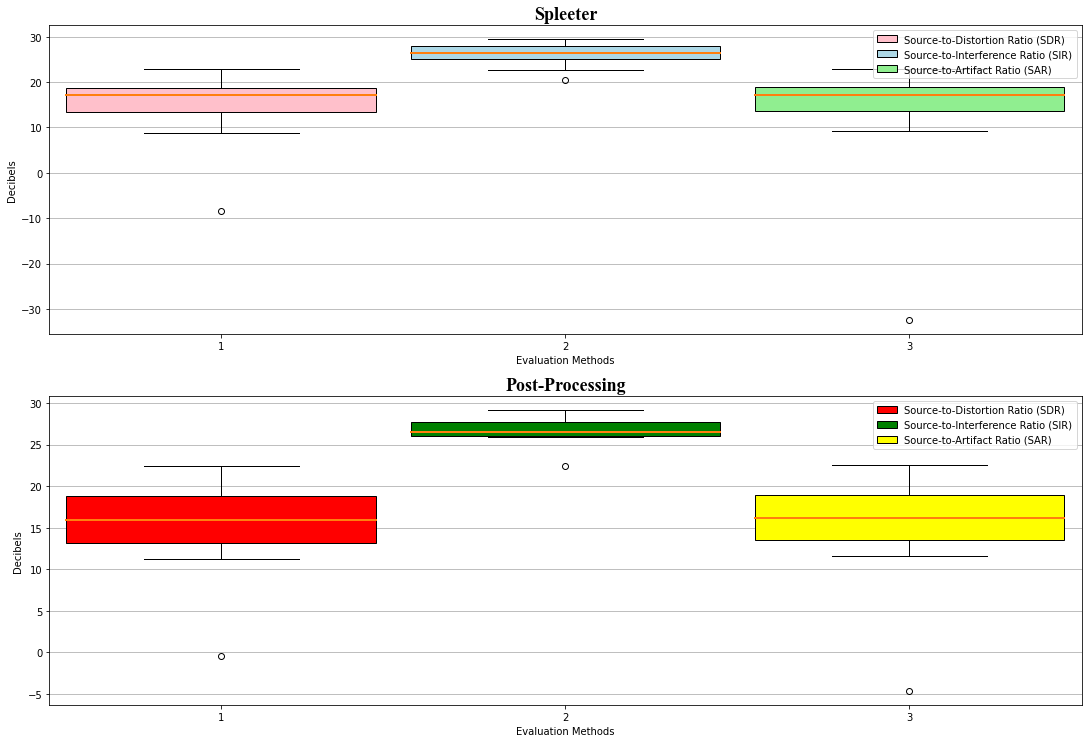

In [20]:
n_sources = 8
evaluate_function(n_sources)

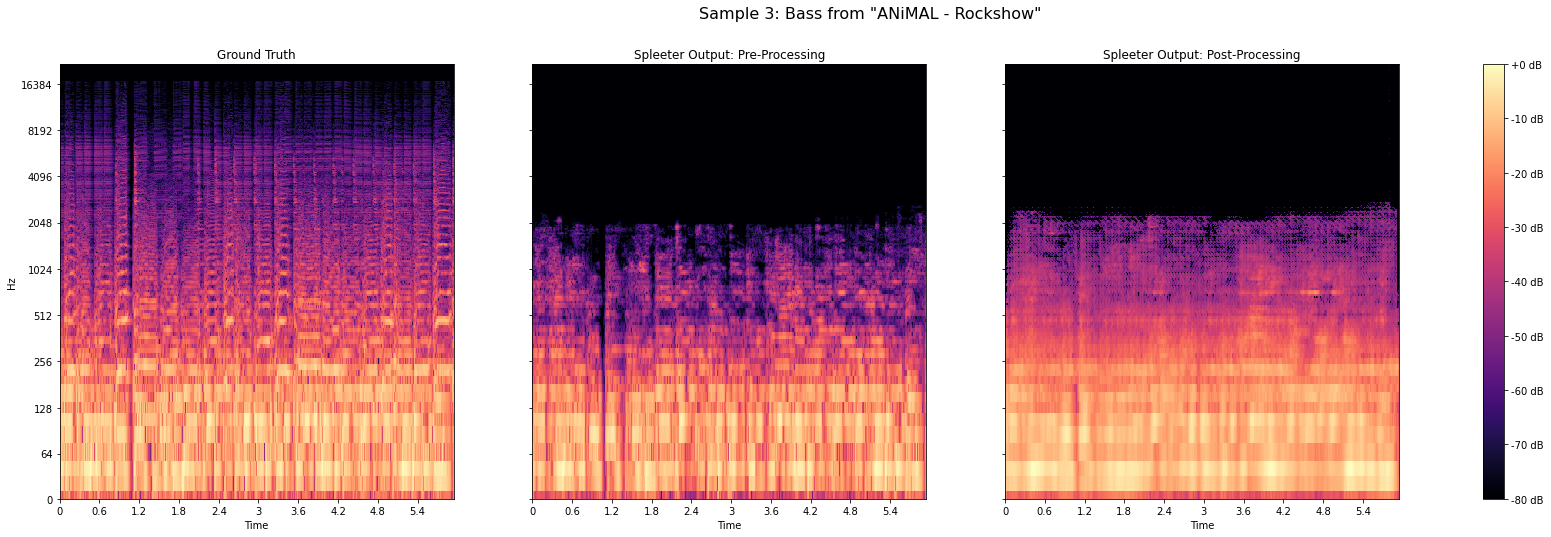

Ground Truth Audio:


Pre-Processed Audio:


Post-Processed Audio:


In [21]:
sample_number = 3 #60


# source separated output audio
plot_function(sample_number)